In [75]:
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import numpy as np
import cartopy
from erddapy import ERDDAP
plt.rcParams.update({'font.size': 14})

### 1. Download glider datasets from our own ERDDAP

In [62]:
# Setup initial ERDDAP connection
e = ERDDAP(
  server="https://erddap.observations.voiceoftheocean.org/erddap",
  protocol="tabledap",
)

# Fetch dataset list

e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas()

datasets = df_datasets.datasetID
# Select only nrt datasets
nrt_datasets = datasets[datasets.str[:3] == "nrt"].values


In [63]:
# Specify variables of interest
e.variables = [
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
    "pressure",
    "oxygen_concentration",
    "44.66",
]

# Download each dataset and save as xarray
glider_datasets = {}
for ds_name in nrt_datasets:
    e.dataset_id = ds_name
    ds = e.to_xarray()
    glider_datasets[ds_name] = ds

### 2. Get nearest SMHI station data

Download SMHI data from [sharkweb](https://sharkweb.smhi.se/hamta-data/). Sharkweb does not appear to have a programatic API, so I have downloaded the data and cached it on another server for download

In [133]:
df = pd.read_csv("https://callumrollo.com/nextcloud/index.php/s/bxBc7QGixQE5kd3/download/sharkweb_physical.txt",
                   sep=";",parse_dates=['Sampling date'], low_memory=False)

In [134]:
stations_df = df.groupby('ID Monitoring station').first()

##### Create map

A scatter plot of SMHI monitoring stations

Text(0.5, 1.0, 'SMHI monitoring stations')

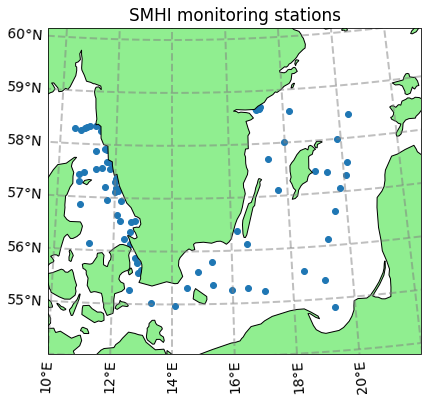

In [239]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=14, central_latitude=56)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([10, 22, 54, 60], crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                              scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None

ax.scatter(stations_df['Sample longitude (DD)'], stations_df['Sample latitude (DD)'], transform=pc)
plt.title("SMHI monitoring stations")

kludge an identifier to uniquiely id each station visit

In [136]:
df["station_visit"] = df['ID Monitoring station'] * 100000 + df['Visit event identifier']

In [137]:
station_visit_df =  df.groupby('station_visit').first()

### 3. Find nearest SMHI profile to glider missions

In [142]:
def format_difference(deg_e, deg_n, ns_ahead):
    """
    Pretty formatting for a lon, lat, time difference between two points
    """
    km_n = (111 * deg_n).round(1)
    km_e = (111 * deg_e * np.cos(np.deg2rad(deg_n))).round(1)
    h_ahead = (np.float64(ns_ahead) / (1e9 * 60 * 60)).round(1)
    if km_n > 0:
        north_str = f"{km_n} km N"
    else:
        north_str = f"{-km_n} km S"
    if km_e > 0:
        east_str = f"{km_e} km E"
    else:
        east_str = f"{-km_e} km W"
    if h_ahead > 0:
        time_str = f"{h_ahead} hours later"
    else:
        time_str = f"{-h_ahead} hours earlier"
    return east_str, north_str, time_str

In [240]:
def smhi_profiles_in_range(lon, lat, time, lon_window, lat_window, time_window, df = station_visit_df, min_depth=80):
    """
    Returns the station IDs of stations within a certain range of a point in space and time
    """
    min_lon = lon - lon_window
    max_lon = lon + lon_window
    min_lat = lat - lat_window
    max_lat = lat + lat_window
    min_time = time - time_window
    max_time = time + time_window
    lon_filter = np.logical_and(df['Sample longitude (DD)'] > min_lon, df['Sample longitude (DD)'] < max_lon)
    lat_filter = np.logical_and(df['Sample latitude (DD)'] > min_lat, df['Sample latitude (DD)'] < max_lat)
    time_filter = np.logical_and(df['Sampling date'] > min_time, df['Sampling date'] < max_time)
    df_in_range = df[lon_filter & lat_filter & time_filter]
    # Filter out shallow stations
    df_in_range = df_in_range[df_in_range['Station water depth'] > min_depth]
    if df_in_range.empty:
        return None
    
    closest_arg = np.argmin(np.abs(df_in_range['Sampling date'] - time))
    closest_datasetid = df_in_range.index[closest_arg]
    return closest_datasetid


In [241]:
def nearest_smhi_station(ds_glider, lat_window=0.5, lon_window=1, time_window = np.timedelta64(10, "D")):
    """
    Finds the nearest SMHI station profile to a supplied glidermission. Uses sharkweb data file
    """
    mean_lon = ds_glider.longitude.mean().values
    mean_lat = ds_glider.latitude.mean().values
    mean_time = ds_glider.time.mean().values
    min_time = str(mean_time-time_window)[:10]
    max_time = str(mean_time+time_window)[:10]
    nearest_profile = smhi_profiles_in_range(mean_lon, mean_lat, mean_time, lat_window, lon_window, time_window)
    if nearest_profile:
        closest_station = station_visit_df[station_visit_df.index == nearest_profile]
        deg_e = mean_lon - closest_station['Sample longitude (DD)'].values[0]
        deg_n = mean_lat - closest_station['Sample latitude (DD)'].values[0]
        time_diff = mean_time - closest_station['Sampling date'].values[0]
        east_diff, north_diff, time_diff = format_difference(deg_e, deg_n, time_diff)
        loc_str = f"Nearest station profile is {east_diff}, {north_diff} & {time_diff} than mean of glider data"
        print(loc_str)
        df_nearest = df[df.station_visit == nearest_profile]
        return df_nearest
    else:
        print("No SMHI profiles found within tolerances")
        return None

smhi_datasets = {}
for name, ds in glider_datasets.items():
    print(f"Trying dataset {name}")
    smhi_datasets[name] = nearest_smhi_station(ds, lat_window=1, lon_window=2)
fail, success = 0, 0
for val in smhi_datasets.values():
    if val is not None:
        success+=1
    else:
        fail+=1
print(f"\nsuccess: {success}, fail: {fail}")  

Trying dataset nrt_SEA068_M27
No SMHI profiles found within tolerances
Trying dataset nrt_SEA069_M9
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M31
Nearest station profile is 97.7 km E, 7.4 km N & 61.5 hours later than mean of glider data
Trying dataset nrt_SEA055_M33
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M35
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M37
Nearest station profile is 23.7 km E, 20.4 km N & 219.0 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M39
No SMHI profiles found within tolerances
Trying dataset nrt_SEA055_M41
Nearest station profile is 6.3 km E, 40.8 km S & 43.1 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M43
No SMHI profiles found within tolerances
Trying dataset nrt_SEA045_M54
Nearest station profile is 22.4 km E, 18.5 km N & 156.5 hours earlier than mean of glider data
Trying dataset nrt_SEA045_M56
Nearest station profile is 28.6 km E, 21.5 km N & 4

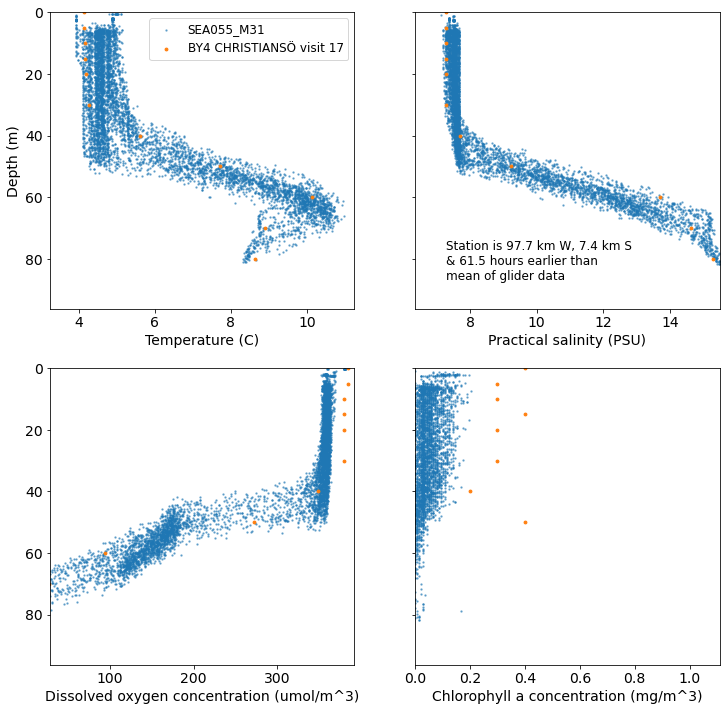

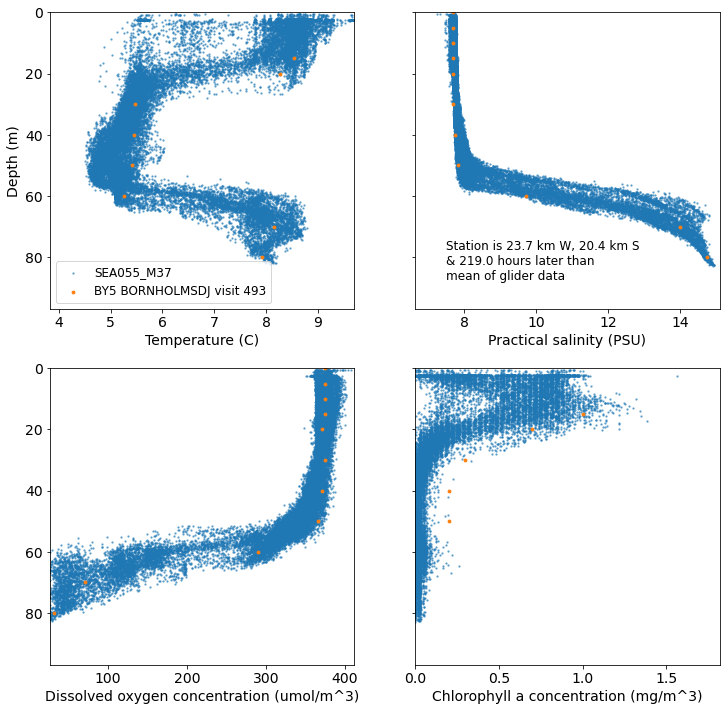

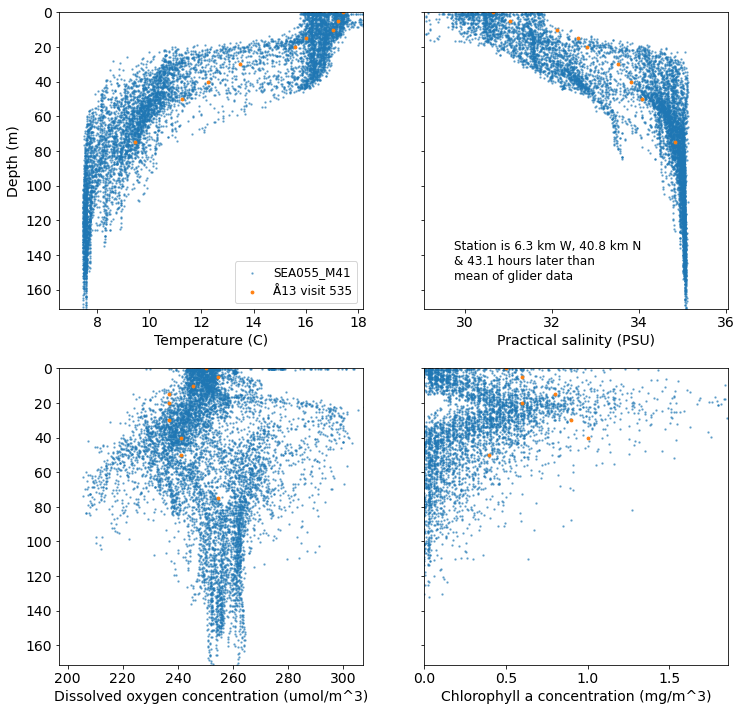

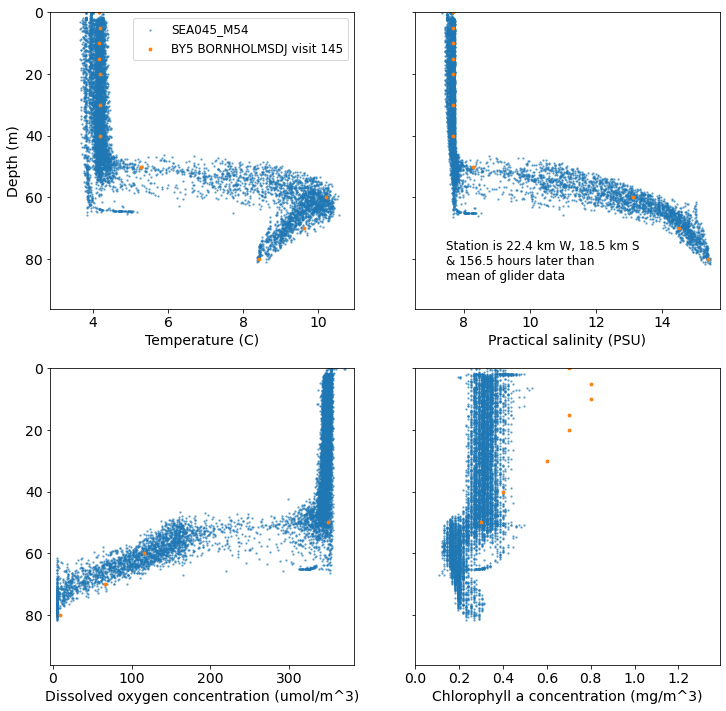

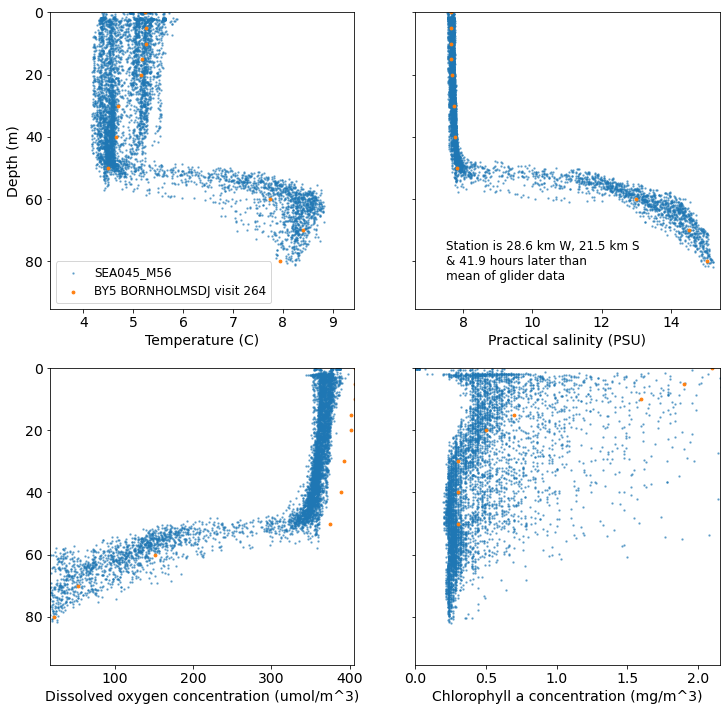

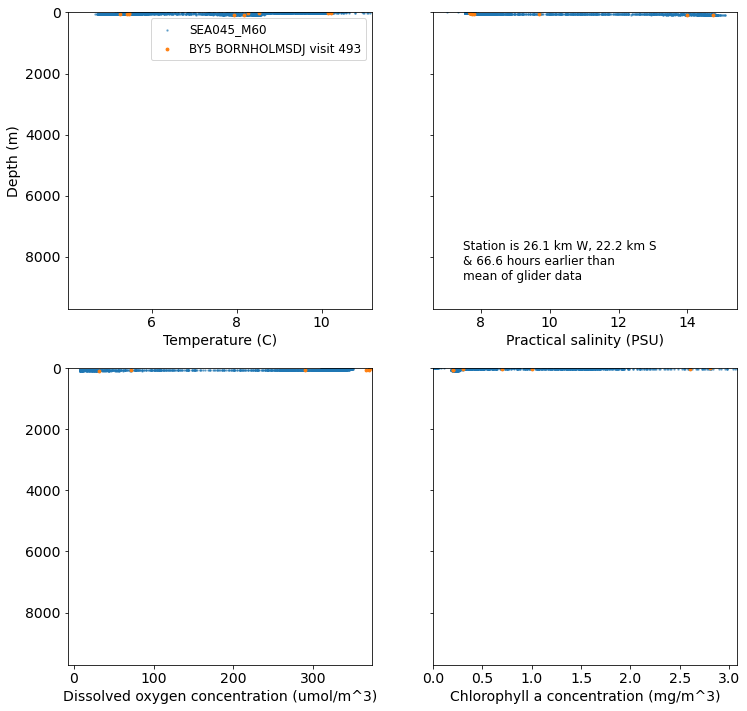

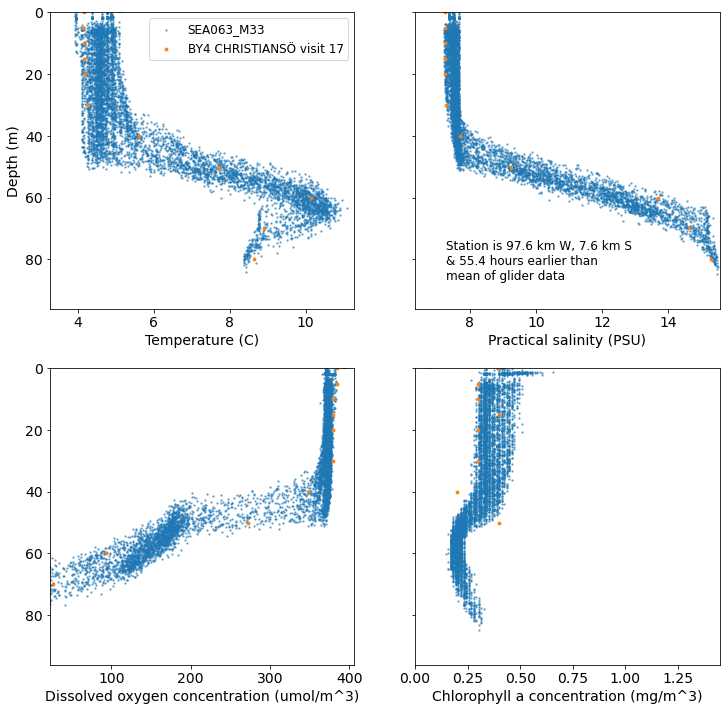

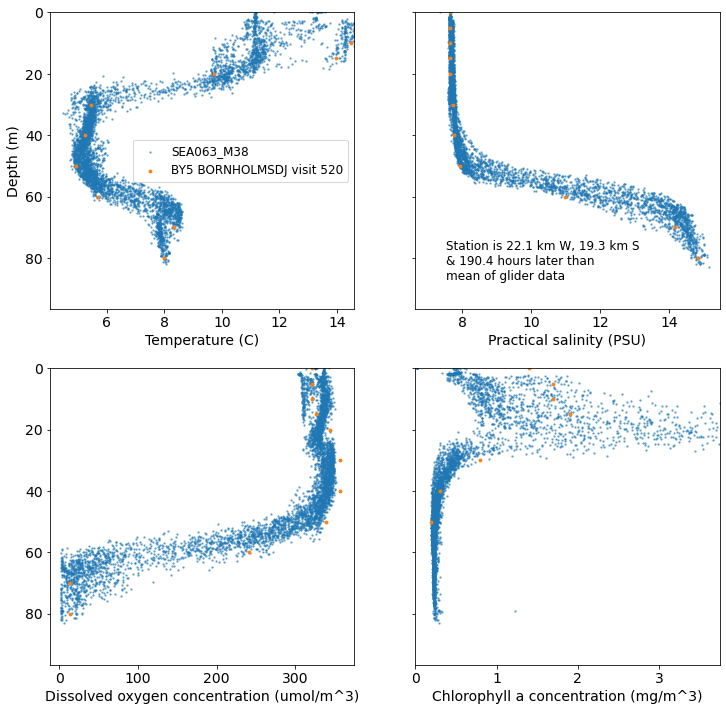

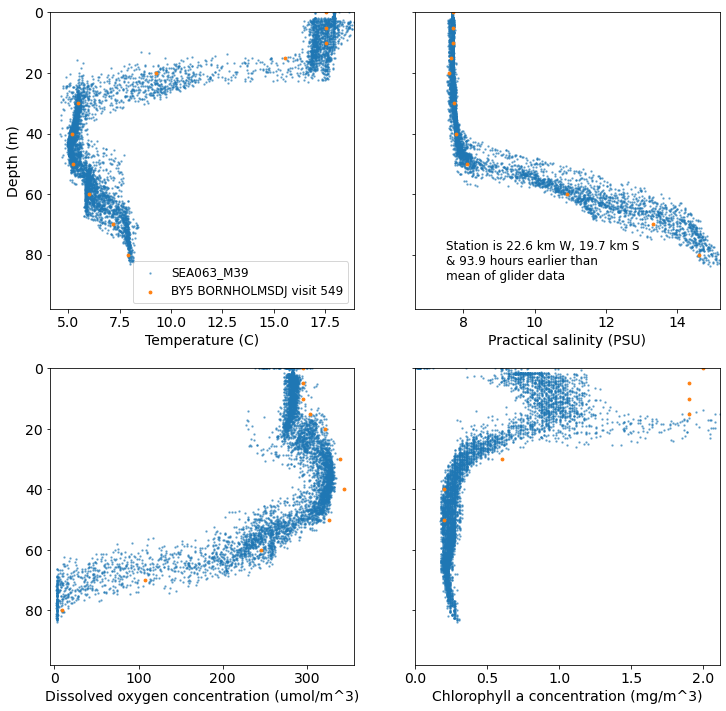

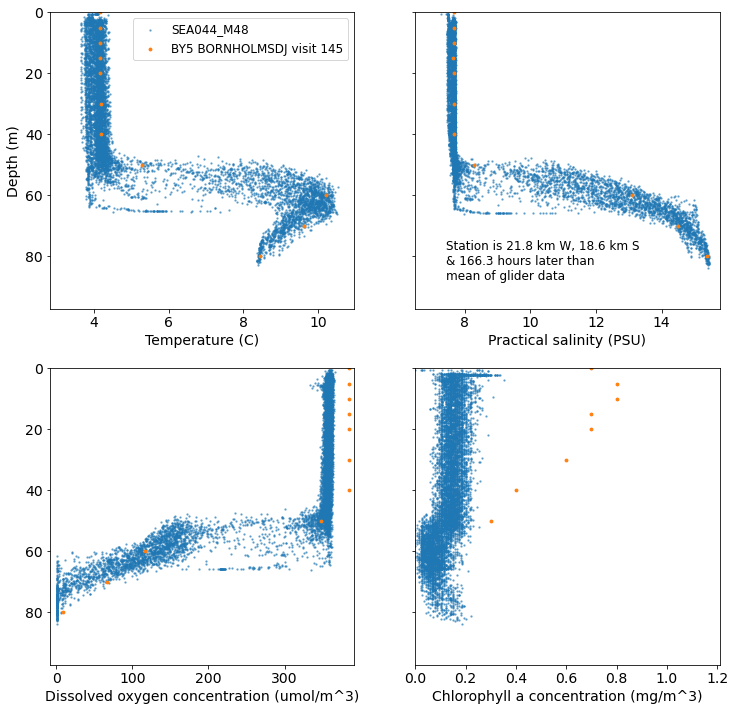

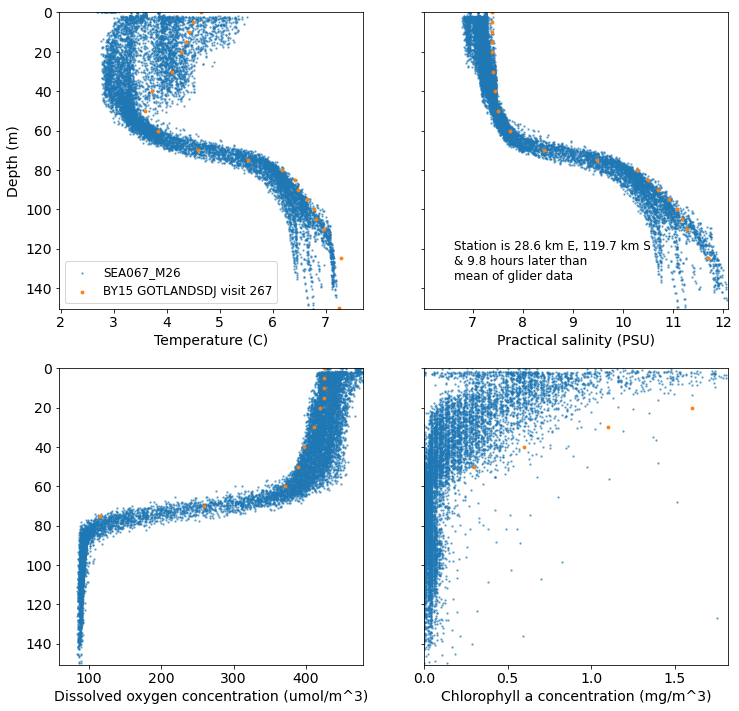

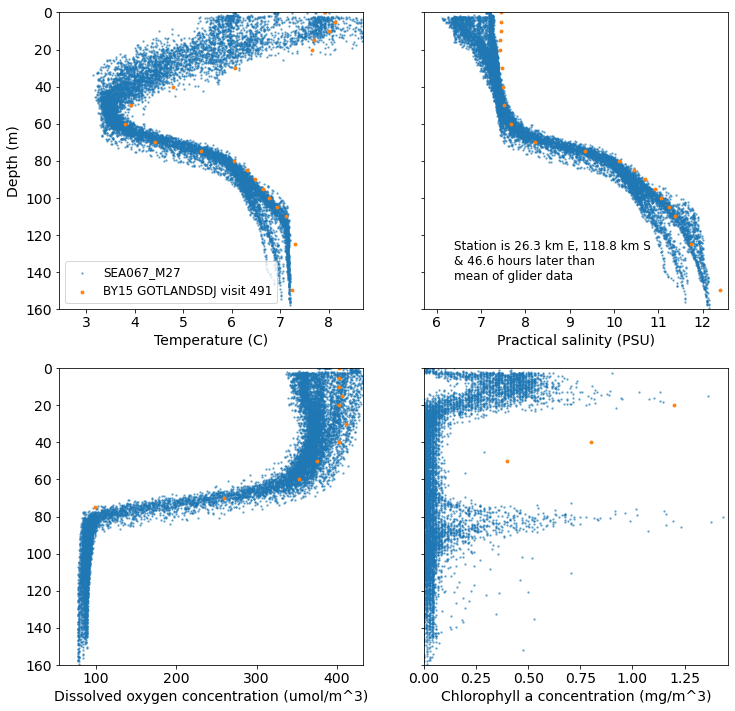

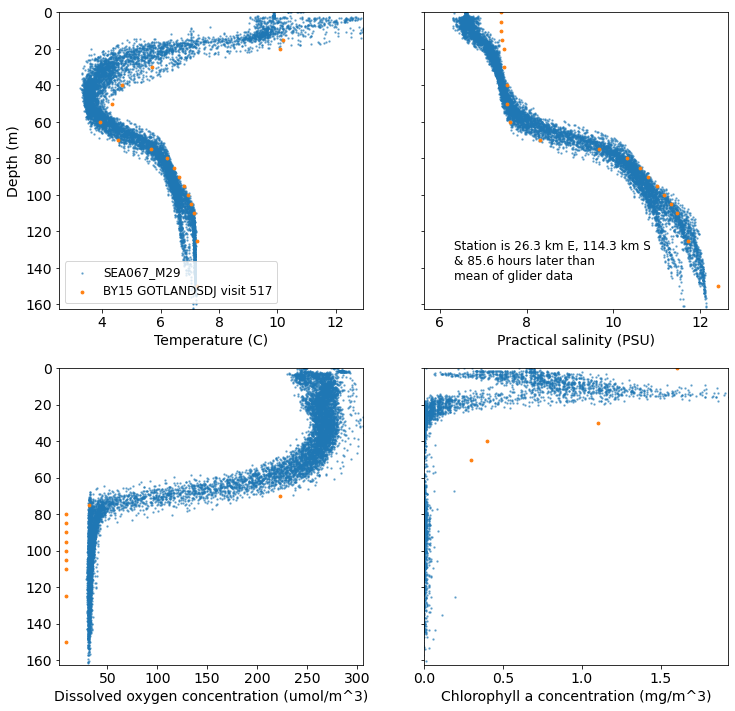

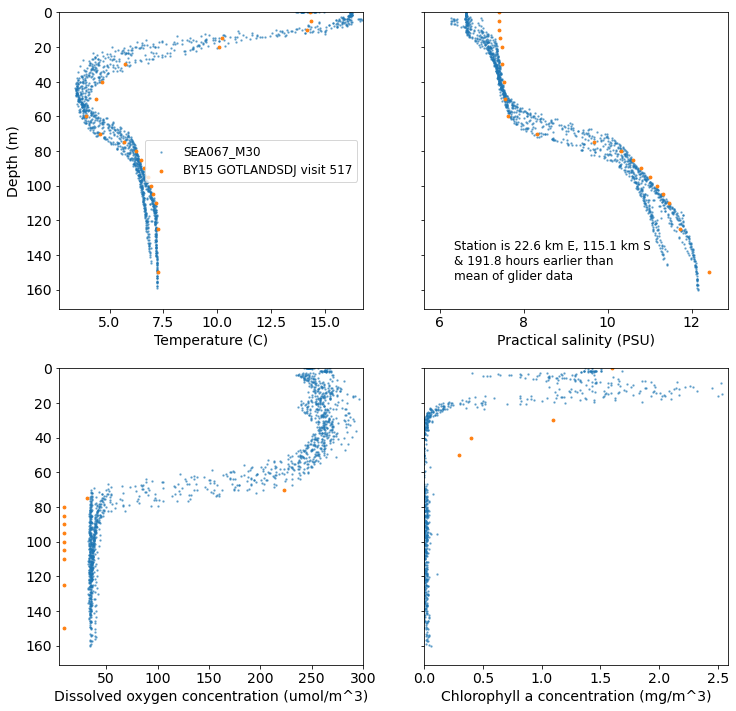

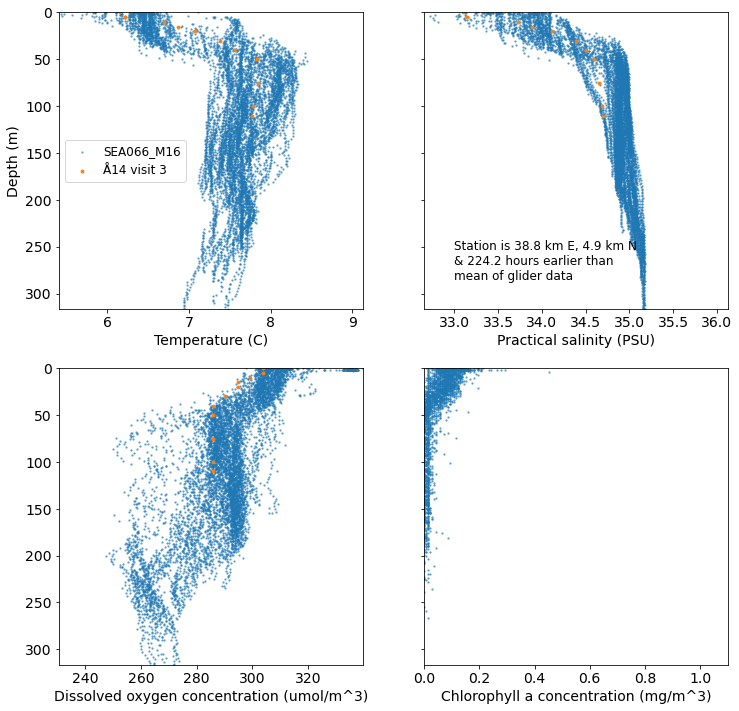

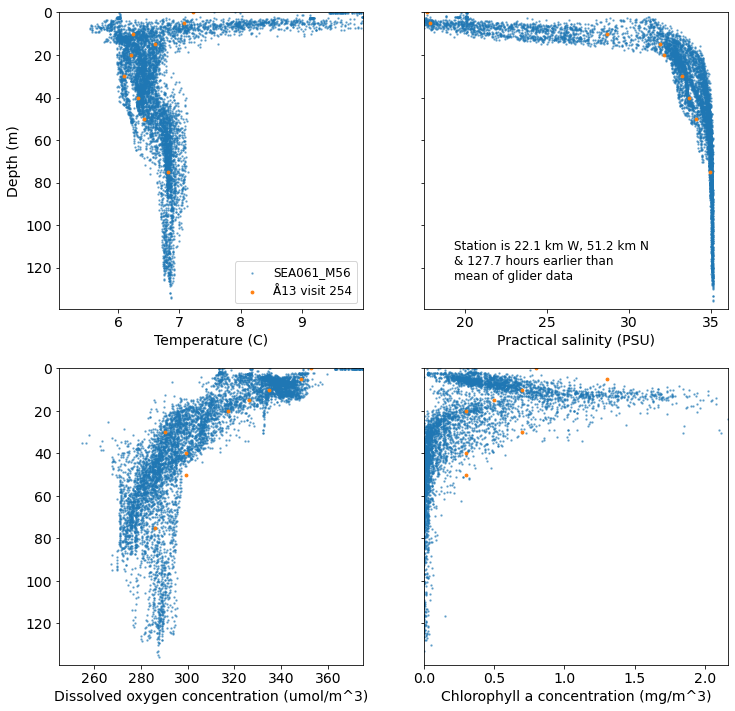

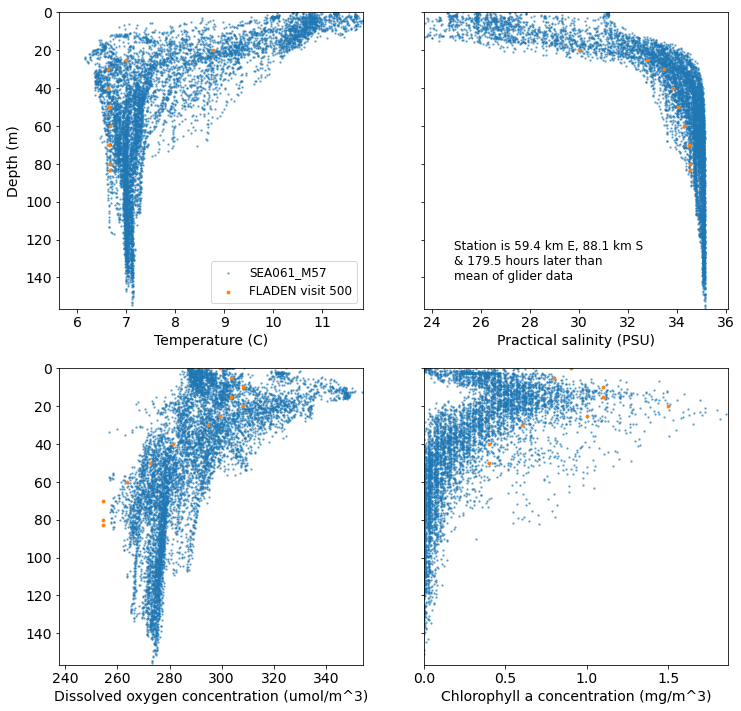

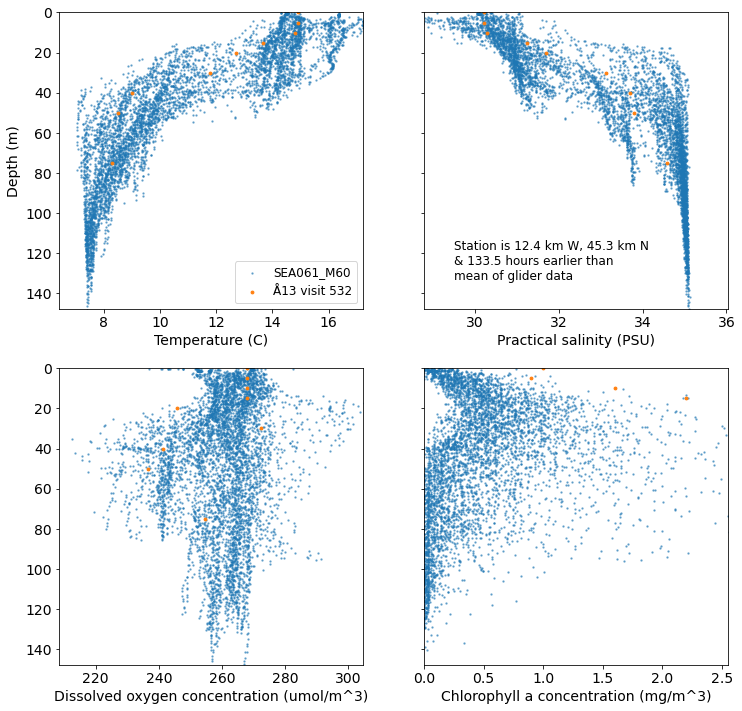

In [242]:
def compare_scatter(name, ds_glider, df_smhi):
    """
    Create scatter plots of temperature and salinity to visually compare glider and SMHI station data
    """
    fig, ax = plt.subplots(2,2, sharey="row", figsize=(12, 12))
    ax = ax.ravel()
    ylim = [0, np.nanpercentile(ds_glider.depth, 99)+20]
    
    
    smhi_name = f"{df_smhi['Station name'].values[0]} visit {df_smhi['Visit event identifier'].values[0]}"
    df_temp = df_smhi[df_smhi['Parameter']=="Temperature CTD"]
    temp_lim = [np.nanpercentile(ds_glider.temperature,5)-1, np.nanpercentile(ds_glider.temperature,95)+1]
    ax[0].scatter(ds_glider.temperature, ds_glider.depth, s=2, label=name[4:], alpha=0.5)
    ax[0].scatter(df_temp["Value"], df_temp['Sampling depth (m)'], s=8, label=smhi_name)
    ax[0].set(ylabel="Depth (m)", xlabel="Temperature (C)", xlim=temp_lim, ylim=ylim)
    ax[0].invert_yaxis()

    df_sal = df_smhi[df_smhi['Parameter']=="Salinity CTD"]    
    sal_lim = [np.nanpercentile(ds_glider.salinity,5)-1, np.nanpercentile(ds_glider.salinity,95)+1]
    ax[1].scatter(ds_glider.salinity, ds_glider.pressure, s=2, alpha=0.5)
    ax[1].scatter(df_sal["Value"], df_sal['Sampling depth (m)'], s=8)
    ax[1].set(xlabel="Practical salinity (PSU)", xlim=sal_lim)
    ax[0].legend(fontsize=12)

    
    df_oxy = df_smhi[df_smhi['Parameter']=="Dissolved oxygen O2 CTD"]    
    oxy_lim = [np.nanpercentile(ds_glider.oxygen_concentration,5)-30, np.nanpercentile(ds_glider.oxygen_concentration,95)+30]
    ax[2].scatter(ds_glider.oxygen_concentration, ds_glider.pressure, s=2, alpha=0.5)
    ax[2].scatter(df_oxy["Value"] * 44.66, df_oxy['Sampling depth (m)'], s=8)
    ax[2].set(xlabel="Dissolved oxygen concentration (umol/m^3)", xlim=oxy_lim, ylim=ylim)
    ax[2].invert_yaxis()

    
    df_chl = df_smhi[df_smhi['Parameter']=="Chlorophyll-a bottle"]    
    chl_lim = [0, np.nanpercentile(ds_glider.chlorophyll,95)+1]
    ax[3].scatter(ds_glider.chlorophyll, ds_glider.pressure, s=2, alpha=0.5)
    ax[3].scatter(df_chl["Value"], df_chl['Sampling depth (m)'], s=8)
    ax[3].set(xlabel="Chlorophyll a concentration (mg/m^3)", xlim=chl_lim)
    
    deg_e = df_smhi['Sample longitude (DD)'].values[0] - np.nanmean(ds_glider.longitude)
    deg_n = df_smhi['Sample latitude (DD)'].values[0] - np.nanmean(ds_glider.latitude)
    time_diff = df_smhi['Sampling date'].values[0] - ds_glider.time.mean()
    east_diff, north_diff, time_diff = format_difference(deg_e, deg_n, time_diff)
    loc_str = f"Station is {east_diff}, {north_diff}\n& {time_diff} than \nmean of glider data"
    ax[1].text(0.1, 0.1, loc_str, fontsize=12, transform=ax[1].transAxes)
    
    plt.savefig(f"figures/smhi_{name}.png")
    #plt.close("all")

for name, df_smhi in smhi_datasets.items():
    if df_smhi is not None:
        compare_scatter(name, glider_datasets[name], df_smhi)

# Comparative map

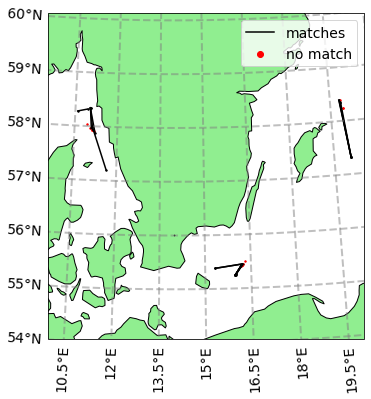

In [243]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=14, central_latitude=56)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([10, 20, 54, 60], crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                              scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None

for name, df_smhi in smhi_datasets.items():
    ds_glider = glider_datasets[name]
    if df_smhi is not None:
        lon = [df_smhi['Sample longitude (DD)'].values[0], np.nanmean(ds_glider.longitude)]
        lat = [df_smhi['Sample latitude (DD)'].values[0], np.nanmean(ds_glider.latitude)]
        ax.scatter(lon, lat, transform=pc, s=2, color="k")
        ax.plot(lon, lat, transform=pc, color="k")
    else:
        ax.scatter(np.nanmean(ds_glider.longitude), np.nanmean(ds_glider.latitude),transform=pc, s=2, color="red")

ax.plot((0,1), (0,1),color="k", label="matches")
ax.scatter((0,1), (0,1),color="red", label="no match")

ax.legend()
fig.savefig(f"figures/smhi_map.png")
